In [2]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df = pd.read_csv('./Datasets/bitcoin_price.csv', parse_dates=['Date'], usecols=['Date','Close'])

In [4]:
df.head()

,Date,Close
0,2017-09-05,4376.53
1,2017-09-04,4236.31
2,2017-09-03,4582.96
3,2017-09-02,4578.77
4,2017-09-01,4892.01


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592 entries, 0 to 1591
Data columns (total 2 columns):
Date     1592 non-null datetime64[ns]
Close    1592 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.0 KB


In [6]:
# convert the date column into a time series with daily frequency

df['Date'] = pd.to_datetime(df['Date'])

In [7]:
indexed_df = df.set_index('Date')

In [8]:
ts = indexed_df['Close']

In [9]:
ts.head()

Date
2017-09-05    4376.53
2017-09-04    4236.31
2017-09-03    4582.96
2017-09-02    4578.77
2017-09-01    4892.01
Name: Close, dtype: float64

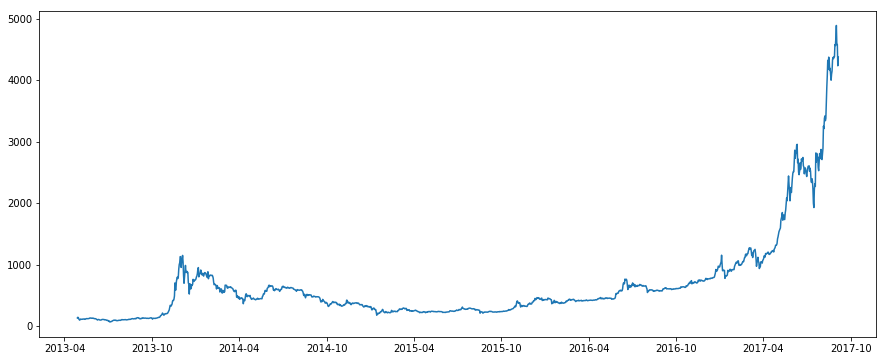

In [10]:
# visualize the time series to see how Bitcoin changes over time

plt.plot(ts)

In [11]:
# resamply by week

ts_week = ts.resample('W').mean()

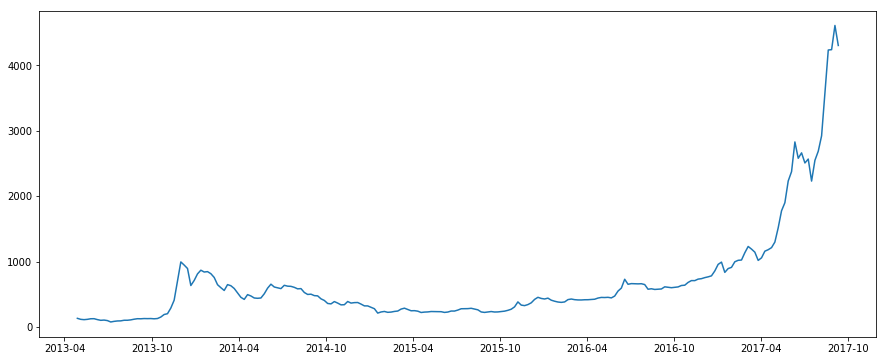

In [12]:
plt.plot(ts_week)

In [15]:
# check for stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

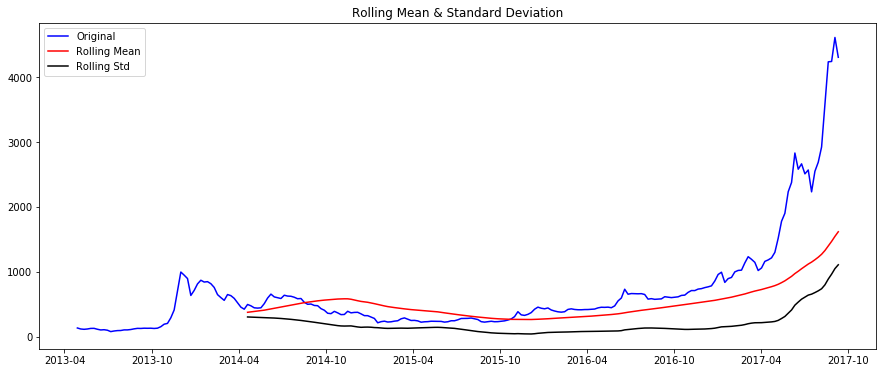

Results of Dickey-Fuller Test:
Test Statistic                   2.167864
p-value                          0.998855
#Lags Used                      12.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (10%)            -2.573952
Critical Value (5%)             -2.875016
dtype: float64


In [16]:
test_stationarity(ts_week)

Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary.
Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

In [17]:
# apply a non linear log transform

ts_week_log = np.log(ts_week)

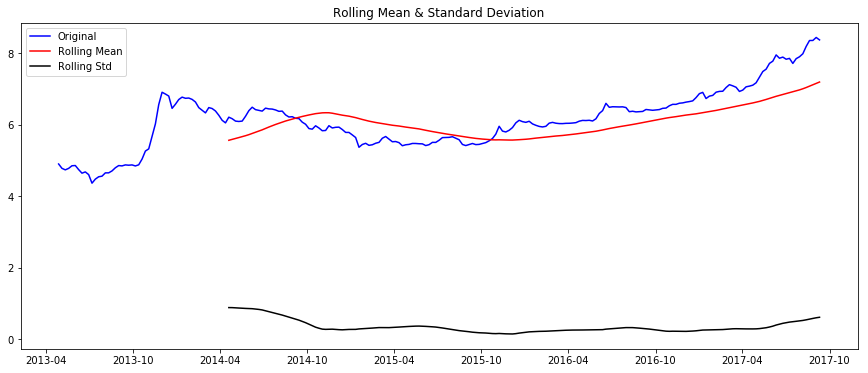

Results of Dickey-Fuller Test:
Test Statistic                  -0.572889
p-value                          0.876991
#Lags Used                       1.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (10%)            -2.573602
Critical Value (5%)             -2.874358
dtype: float64


In [18]:
test_stationarity(ts_week_log)

The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05.

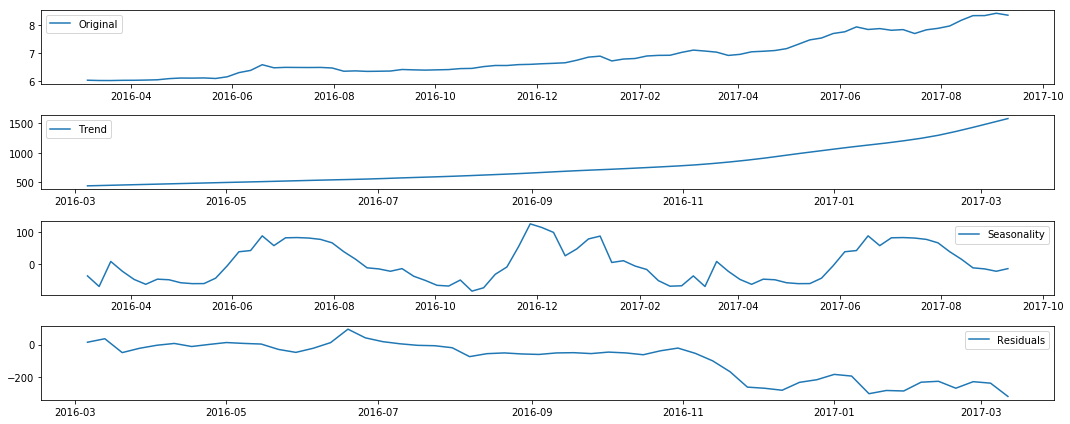

In [19]:
# remove trend and seasonality with decomposition

decomposition = seasonal_decompose(ts_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_week_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

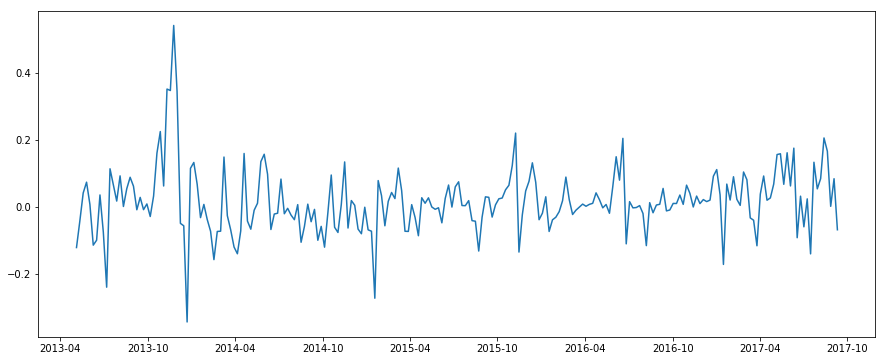

In [20]:
# remove trend and seasonality with differencing

ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

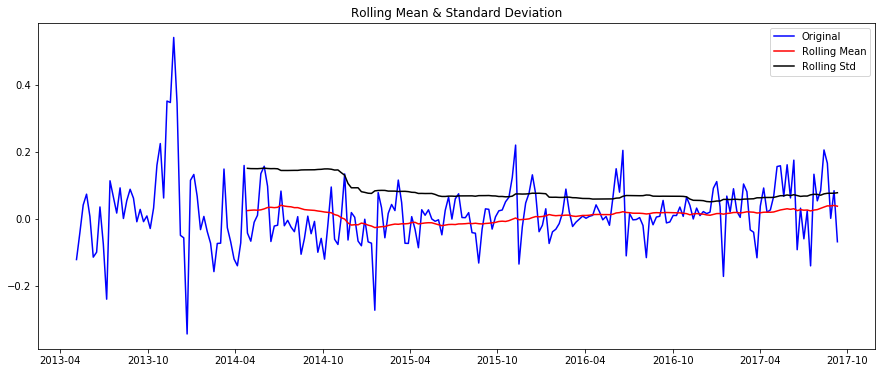

Results of Dickey-Fuller Test:
Test Statistic                -1.004834e+01
p-value                        1.434514e-17
#Lags Used                     0.000000e+00
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (10%)          -2.573602e+00
Critical Value (5%)           -2.874358e+00
dtype: float64


In [21]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

In [22]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=458.605640, expected=446.637143
predicted=444.475188, expected=474.691429
predicted=489.987415, expected=551.005714
predicted=591.498148, expected=596.484286
predicted=619.219760, expected=731.377143
predicted=805.742890, expected=654.824286
predicted=629.826537, expected=664.880000
predicted=669.379962, expected=662.717143
predicted=667.161280, expected=661.177143
predicted=662.961635, expected=663.445714
predicted=668.172652, expected=650.282857
predicted=648.006089, expected=579.128571
predicted=554.675398, expected=586.241429
predicted=589.933671, expected=575.837143
predicted=575.969710, expected=578.801429
predicted=580.975168, expected=583.108571
predicted=588.891397, expected=615.854286
predicted=631.642134, expected=608.304286
predicted=609.890910, expected=602.470000
predicted=601.190757, expected=608.462857
predicted=614.844329, expected=614.405714
predicted=618.945908, expected=636.242857
predicted=649.164405, expected=64

In [24]:
predictions_series = pd.Series(predictions, index = test.index)

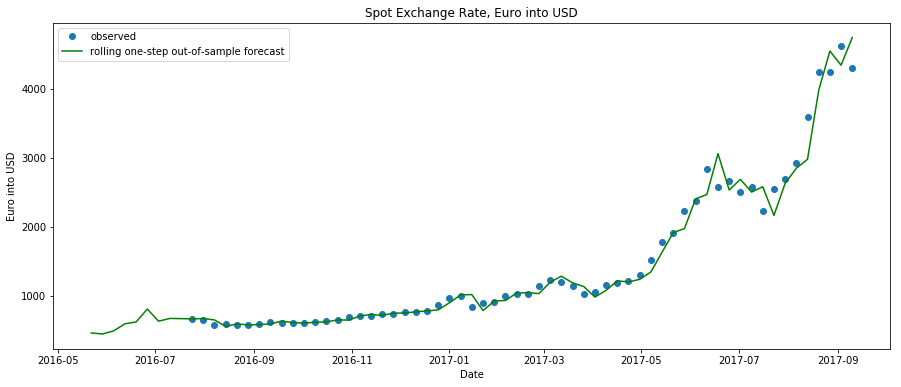

In [25]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')